# Examining Embedding Vectors with Sentiment Analysis Model

This notebook aims to implement a very simple sentiment analysis model to explore how the model learns word embedding vectors to predict sentence sentiment. The 'yelp_popularity' dataset will be imported from Huggingface for this analysis.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [ ]:
pip install datasets

In [ ]:
from datasets import load_dataset

yelp_dataset = load_dataset("fancyzhx/yelp_polarity")
df_train = pd.DataFrame(yelp_dataset['train'])
df_test = pd.DataFrame(yelp_dataset['test'])
print(df_train.head())

                                                text  label
0  Unfortunately, the frustration of being Dr. Go...      0
1  Been going to Dr. Goldberg for over 10 years. ...      1
2  I don't know what Dr. Goldberg was like before...      0
3  I'm writing this review to give you a heads up...      0
4  All the food is great here. But the best thing...      1


Preprocessing involves the following steps:
1. Text Cleaning: The `remove_and_lower` function removes special characters and converts the text to lowercase, ensuring consistency.
2. Dictionary Creation: The `make_dictionary` function builds two mappings: `dictionary_index` (word-to-index) and `dictionary_word` (index-to-word). A padding token (" ") is assigned index 0. The function also tracks the maximum sentence length (`max_len`).
3. Sentence Indexing: Each sentence is tokenized, converted to word indices, and padded to the maximum sentence length. These indexed sentences are stored as `train_document_index`.
4. Tensor Conversion: Both the indexed sentences and labels are converted to PyTorch tensors, ready for model training.

In [ ]:
import re

def remove_and_lower(sentence):
  return re.sub(r'[^\w\s]', '', sentence).lower()

def make_dictionary(document):
  max_len = 0
  dictionary_index = {}
  dictionary_word = {}
  dictionary_index[" "] = 0
  dictionary_word[0] = " "
  index = 1
  for sentence in document:
    sentence = remove_and_lower(sentence)
    sentence = sentence.split(" ")
    if len(sentence) > max_len:
      max_len = len(sentence)
    for word in sentence:
      if word not in dictionary_index:
        dictionary_index[word] = index
        dictionary_word[index] = word
        index += 1
  return dictionary_index, dictionary_word, max_len

train_document = df_train['text']
dictionary_index, dictionary_word, max_len = make_dictionary(train_document)

train_document_index = []
for sentence in train_document:
  sentence_index = []
  sentence = remove_and_lower(sentence)
  for word in sentence.split(" "):
    sentence_index.append(dictionary_index[word])
  if len(sentence_index) < max_len:
    sentence_index += [0] * (max_len - len(sentence_index))
  train_document_index.append(sentence_index)

train_document_index = torch.tensor(train_document_index)
train_label = torch.tensor(df_train['label'], dtype=torch.float32)

In [ ]:
test_document = df_test['text']
test_document_index = []
for sentence in test_document:
  sentence_index = []
  sentence = remove_and_lower(sentence)
  for word in sentence.split(" "):
    if word in dictionary_index:
      sentence_index.append(dictionary_index[word])
    else:
      sentence_index.append(0)
  if len(sentence_index) < max_len:
    sentence_index += [0] * (max_len - len(sentence_index))
  test_document_index.append(sentence_index)

test_document_index = torch.tensor(test_document_index)
test_label = torch.tensor(df_test['label'], dtype=torch.float32)

In [ ]:
print(train_document_index.shape)
print(train_document_index[0])

torch.Size([560000, 1059])
tensor([1, 2, 3,  ..., 0, 0, 0])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


The `sentiment_analysis` class defines a simple neural network model for sentiment analysis:
1. The constructor (`__init__`) initializes two layers:
   - An embedding layer (`nn.Embedding`) that converts input word indices into dense vectors of size `d`. Padding is handled with index 0.
   - A fully connected layer (`nn.Linear`) that maps the averaged embedding to a single output for sentiment prediction.
2. The `forward` function processes input by:
   - Applying the embedding layer to the input.
   - Averaging the embeddings along the sentence (dim=1).
   - Passing the result through the fully connected layer.
   - Using the sigmoid function to output a probability score for sentiment classification.

In [ ]:
class sentiment_analysis(nn.Module):
  def __init__(self, dictionary_len, d):
    super(sentiment_analysis, self).__init__()
    self.embedding = nn.Embedding(dictionary_len, d, padding_idx=0)
    self.fc = nn.Linear(d, 1)

  def forward(self, x):
    out = self.embedding(x)
    out = torch.mean(out, dim=1)
    out = self.fc(out)
    out = torch.sigmoid(out)
    return out

from torch.utils.data import random_split

train_size = int(0.8 * len(train_label))
val_size = len(train_label) - train_size
train_dataset = torch.utils.data.TensorDataset(train_document_index, train_label)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=64, shuffle=True)

LR = 0.001
EPOCH = 20
model = sentiment_analysis(len(dictionary_index), 10).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

val_losses = []

for epoch in range(EPOCH):
  model.train()
  for batch_idx, (data, target) in enumerate(train_dataloader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target.unsqueeze(1))
    loss.backward()
    optimizer.step()
  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_acc = 0
    total = 0
    for batch_idx, (data, target) in enumerate(val_dataloader):
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      predicted = (output >= 0.5).float()
      total += target.size(0)
      val_acc += (predicted.squeeze() == target).sum().item()
      val_loss += criterion(output, target.unsqueeze(1))
  print(f'Epoch: {epoch + 1}, Loss: {val_loss/len(val_dataloader):.4f}, Accuracy: {val_acc/total:.4f}')
  val_losses.append(val_loss/len(val_dataloader))

Epoch: 1, Loss: 0.3119, Accuracy: 0.8998
Epoch: 2, Loss: 0.2312, Accuracy: 0.9191
Epoch: 3, Loss: 0.2100, Accuracy: 0.9252
Epoch: 4, Loss: 0.2007, Accuracy: 0.9282
Epoch: 5, Loss: 0.1958, Accuracy: 0.9304
Epoch: 6, Loss: 0.1926, Accuracy: 0.9318
Epoch: 7, Loss: 0.1912, Accuracy: 0.9327
Epoch: 8, Loss: 0.1899, Accuracy: 0.9332
Epoch: 9, Loss: 0.1889, Accuracy: 0.9336
Epoch: 10, Loss: 0.1883, Accuracy: 0.9335
Epoch: 11, Loss: 0.1880, Accuracy: 0.9338
Epoch: 12, Loss: 0.1879, Accuracy: 0.9341
Epoch: 13, Loss: 0.1883, Accuracy: 0.9344
Epoch: 14, Loss: 0.1885, Accuracy: 0.9342
Epoch: 15, Loss: 0.1890, Accuracy: 0.9343
Epoch: 16, Loss: 0.1896, Accuracy: 0.9342
Epoch: 17, Loss: 0.1911, Accuracy: 0.9341
Epoch: 18, Loss: 0.1918, Accuracy: 0.9341
Epoch: 19, Loss: 0.1935, Accuracy: 0.9339
Epoch: 20, Loss: 0.1944, Accuracy: 0.9340


In [ ]:
test_dataset = torch.utils.data.TensorDataset(test_document_index, test_label)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

model.eval()
with torch.no_grad():
  test_acc = 0
  total = 0
  for batch_idx, (data, target) in enumerate(test_dataloader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    predicted = (output >= 0.5).float()
    total += target.size(0)
    test_acc += (predicted.squeeze() == target).sum().item()
print("Accuracy: ", test_acc/total)

38000
Accuracy:  0.9371578947368421


Let us now examine the embedding vectors. We will see that the embedding vectors are very sparse. In order to show sparsity, I flattened all the embedding vectors and counted
the frequencies of the weights with bin = 100.

In [ ]:
embeddings = model.embedding.weight.cpu().detach().numpy()
print(embeddings)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-4.195424    4.419255    3.5153573  ...  3.9291623   7.242612
  -5.7766433 ]
 [-0.8198489  -0.74195004 -0.9340372  ... -0.4009707   0.31633818
   0.16047087]
 ...
 [-1.325691   -2.4386294   0.16631699 ... -0.62415296  1.0907253
   1.2004197 ]
 [-1.048458   -1.0592463  -0.8593047  ... -0.2742967  -0.05222429
   0.67845964]
 [-0.93417215  0.40918928  1.8825599  ...  0.77232844  0.21557662
   0.01402013]]


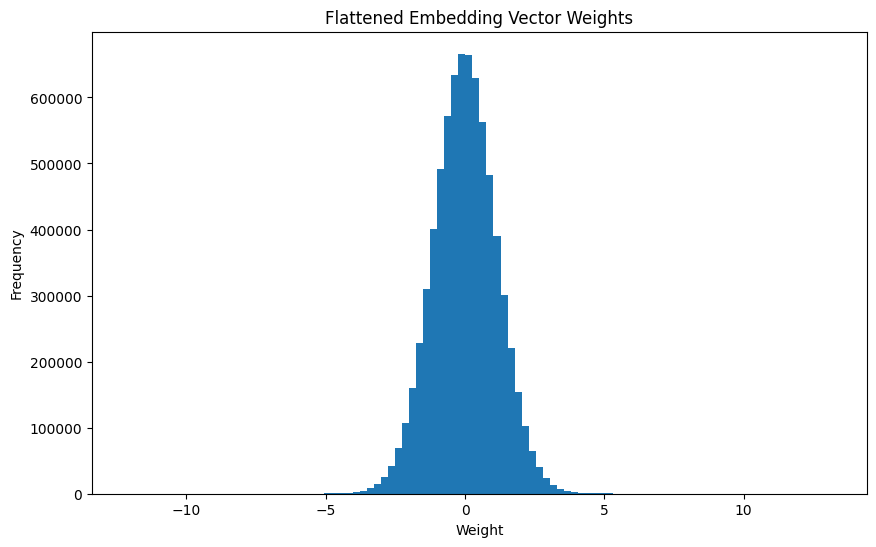

In [ ]:
flattened_weights = embeddings.flatten()

plt.figure(figsize=(10, 6))
plt.hist(flattened_weights, bins=100)
plt.title("Flattened Embedding Vector Weights")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

Clearly, we see that most of the weights are centered around 0, showing that
the learned vectors are very sparse. To further show that the vectors are indeed
sparse, I used T-SNE with two dimensions, and the results are shown below.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


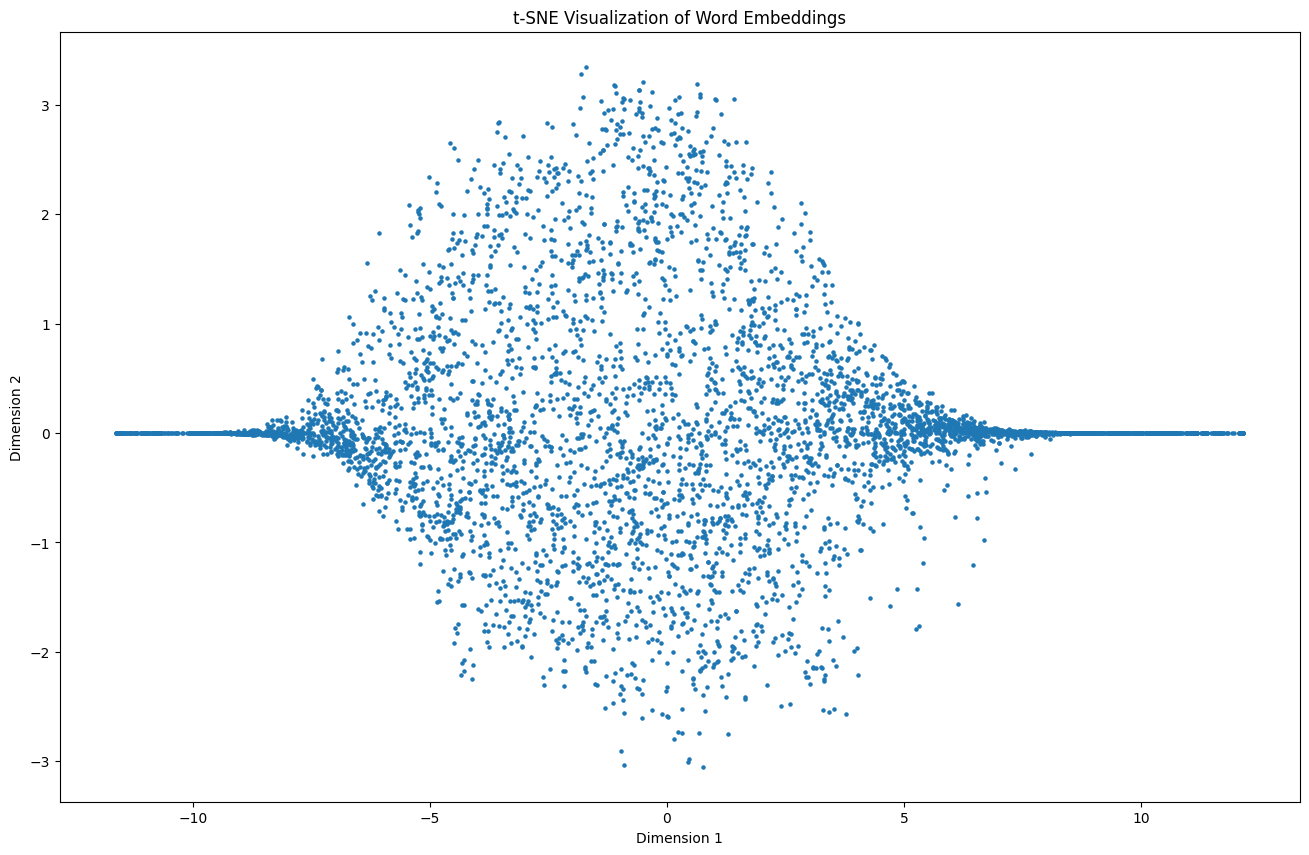

In [ ]:
from sklearn.manifold import TSNE
num_samples = 5000
subset_embeddings = embeddings[:num_samples]

tsne = TSNE(n_components=2, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(subset_embeddings)

plt.figure(figsize=(16, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

We see that many of the points are along Dimension2 = 0, which means
that many of the embedding vectors share a common features, and the fact
that it is specifically along the axis means that the dimension can be collapsed,
possibly hinting that the vectors are sparse. We can conclude this because we
saw in the histogram that the learned embedding vectors does indeed contain a
lot of zeros. Therefore, the horizontal line of the t-SNE plot most likely refers
to the commonality of sparsity among the embedding vectors.

To determine the words that were most influential in the model predictions, I
took the sum of the absolute value of each embedding vectors and sorted from
greatest to smallest sum. The top 40 words along with their weight magnitude
are shown below. 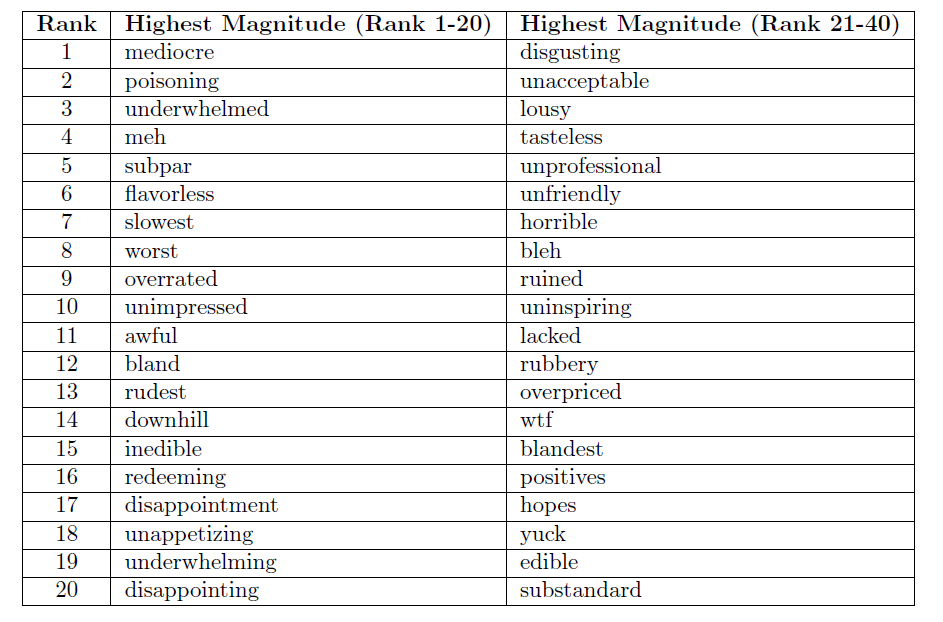You can run the code below to see the outputs.

In [ ]:
important_words = np.argsort([np.sum(embedding) for embedding in embeddings])[::-1]
print("Most important words (embeddings) :")
for i in range(50):
  print(dictionary_word[important_words[i]])

print(" ")

In [ ]:
important_words = np.argsort([np.sum(np.abs(embedding)) for embedding in embeddings])[::-1]
for i in range(50):
  print(dictionary_word[important_words[i]])

It is evident that our model has successfully identified words that are important
for sentiment analysis. All the words present in the table are impactful
words that directly contributes to the sentiment. We can take a closer look at
the learned embedding vectors for a single positive and negative word. Here, I
chose the word ”mediocre” and ”perfection” from the list of learned embedding
vectors. The weights are shown below.
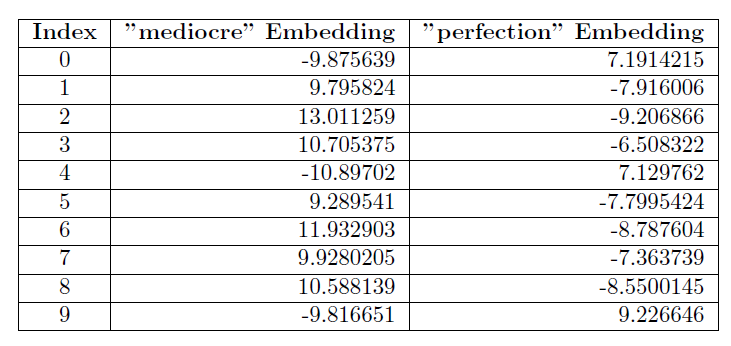

In [ ]:
print(embeddings[dictionary_index["mediocre"]])
print(embeddings[dictionary_index["perfection"]])

[ -9.875639    9.795824   13.011259   10.7053795 -10.89702     9.289541
  11.932903    9.9280205  10.588139   -9.816651 ]
[ 7.1914215 -7.916006  -9.206866  -6.508322   7.129762  -7.7995424
 -8.787604  -7.363739  -8.5500145  9.226646 ]


Clearly, we see that the individual component signs correspond to whether
the words embed positive or negative meanings. Therefore, we can say that
both the large weight components and the signs of the learned embeddings correspond
to the positive and negative sentiments. Here, we examine other words/embedding vectors that has the same sign patterns as 'mediocre' and 'perfection'.

In [ ]:
negative = np.sign(embeddings[dictionary_index["mediocre"]])
positive = np.sign(embeddings[dictionary_index["perfection"]])
count = 0
for i in range(len(embeddings)):
  if count < 30:
    if np.array_equal(np.sign(embeddings[i]), negative):
      print("Negative: ", dictionary_word[i])
      count += 1
    elif np.array_equal(np.sign(embeddings[i]), positive):
      print("Positive: ", dictionary_word[i])
      count += 1

Negative:  unfortunately
Negative:  frustration
Positive:  patient
Negative:  terrible
Negative:  answers
Negative:  takes
Negative:  repeated
Negative:  patients
Negative:  isnt
Negative:  not
Negative:  aggravation
Positive:  regret
Positive:  great
Positive:  judge
Positive:  questions
Positive:  thorough
Positive:  aspect
Positive:  life
Positive:  johnson
Negative:  left
Positive:  caring
Negative:  interested
Negative:  joke
Negative:  worse
Negative:  incompetent
Negative:  no
Negative:  practice
Negative:  attitude
Negative:  favor
Negative:  write


Now, we examine the weights of the fully connected layer.

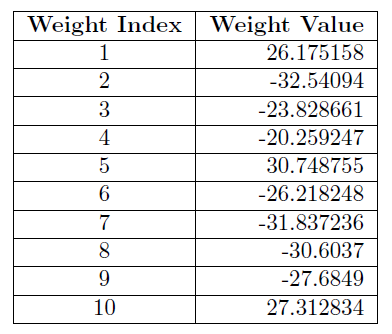

In [ ]:
fc_weights = model.fc.weight.cpu().detach().numpy()[0]
print(fc_weights)

[ 26.175158 -32.54094  -23.828661 -20.259247  30.748755 -26.218248
 -31.837236 -30.6037   -27.6849    27.312834]


Clearly, vector w is not sparse. We see that weight index 5 is the most
positive, and weight index 2 is the most negative. Below are the words that
correspond to the top 10 highest absolute weight in index 5 (positive words),
and top 10 highest absolute weight in index 2 (negative words).

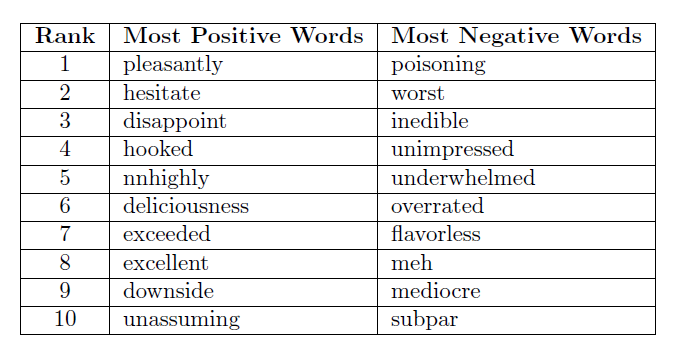

In [ ]:
indices = sorted(range(len(embeddings)), key=lambda i: embeddings[i][4], reverse=True)[:10]
for index in indices:
  print(dictionary_word[index])

pleasantly
hesitate
disappoint
hooked
nnhighly
deliciousness
exceeded
excellent
downside
unassuming


In [ ]:
indices = sorted(range(len(embeddings)), key=lambda i: embeddings[i][1], reverse=True)[:10]
for index in indices:
  print(dictionary_word[index])

poisoning
worst
inedible
unimpressed
underwhelmed
overrated
flavorless
meh
mediocre
subpar


Overall, we can see that the greatest and smallest weights of the FC layer
does have correlation with the positive and negative sentiment embedding vector/
words. We see that top 10 negative words are correct, but we see that
’disappoint’ is also in the top 10 positive words. This may contribute to the
non-perfect accuracy of our model. Nevertheless, we see that the model has
successfully learned the weights that would give higher contribution to positive
and negative sentiment words that leads to the correct model output.